# IMPORTS

In [1]:
import sys 
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import keras
from PIL import Image
from keras.applications import imagenet_utils
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.options.plotting.backend = "plotly"
import tensorflow_model_optimization as tfmot
from tensorflow.keras.applications import mobilenet_v2,resnet,densenet
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
from torchvision import datasets, transforms
import shutil
import tensorflow_datasets as tfds

In [2]:
# print version
print('tensorflow:', tf.__version__)
print('keras     :', tf.keras.__version__)

tensorflow: 2.8.0
keras     : 2.8.0


# Prepare the dataset

In [3]:
SPLIT_WEIGHTS = (8, 1, 1)
#splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
splits = ("train[:80%]", "train[:10%]", "train[:10%]")

In [4]:
(raw_train, raw_validation, raw_test), info = tfds.load(name="tf_flowers",
                                                        with_info=True,
                                                        split=list(splits),
                                                        as_supervised=True)

In [5]:
total_num_examples = info.splits['train'].num_examples

print('total num examples:', total_num_examples)
print('total num examples % 100:', total_num_examples % 100)
print('total num examples =', total_num_examples - (total_num_examples % 100), '+', total_num_examples % 100)

print('num test :', int(3600 * 0.1 + 7))
print('num val  :', int(3600 * 0.1 + 7))
print('num train:', int(3600 * 0.8 + (70 - 14)))

total num examples: 3670
total num examples % 100: 70
total num examples = 3600 + 70
num test : 367
num val  : 367
num train: 2936


In [6]:
IMG_SIZE = 224
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 32

In [7]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # image = (image/127.5) - 1

    # Resize the image if required
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

In [8]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [9]:
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.6)

    return image, label

In [10]:
train = train.map(augment_data)
train = train.cache()
train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation = validation.batch(BATCH_SIZE)
test = test.batch(1)

train = train.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
print(train)
print(validation)
print(test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


## Display train image

In [12]:
# Get the function which converts label indices to string
get_label_name = info.features['label'].int2str

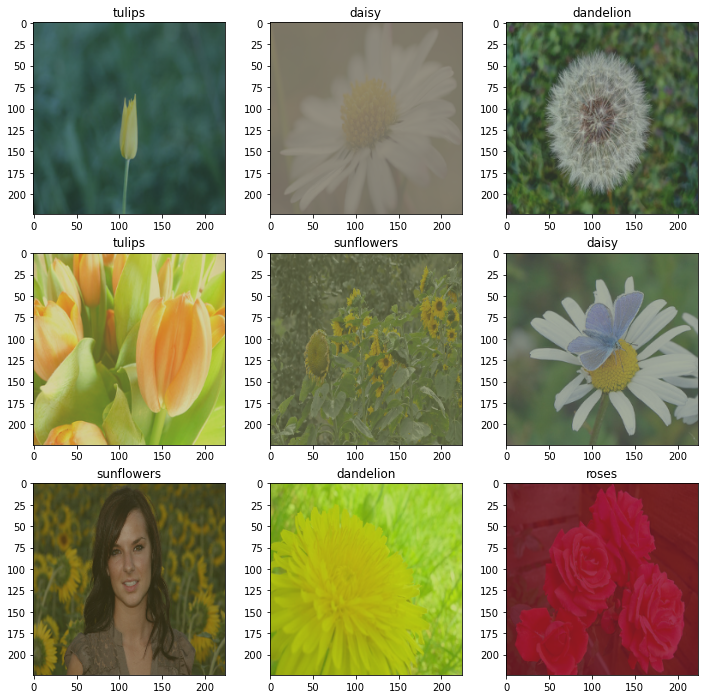

In [13]:
plt.figure(figsize=(12,12)) 

for batch in train.take(1):
  # print(batch)
  for i in range(9):
    image, label = batch[0][i], batch[1][i]
    plt.subplot(3, 3, i+1)
    plt.imshow(image.numpy())
    plt.title(get_label_name(label.numpy()))
    plt.grid(False)    

# Train model

# Build model

In [16]:
net_model = mobilenet_v2
base_model=net_model.MobileNetV2(include_top=False, 
                                    weights='imagenet', 
                                    input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False
    
last_l = base_model.output
pool = tf.keras.layers.GlobalAveragePooling2D()(last_l)
outputs = tf.keras.layers.Dense(info.features['label'].num_classes, activation='softmax')(pool)
model = tf.keras.Model(base_model.input, outputs)

In [17]:
base_model.trainable = True
for layer in base_model.layers[:108]:
    layer.trainable = False

In [19]:
base_learning_rate = 1e-4
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss = 'sparse_categorical_crossentropy',
    metrics = ["accuracy"]
)

In [20]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

## Training

In [22]:
num_train = 2936
num_val =  367
num_test = 367

steps_per_epoch = round(num_train) // BATCH_SIZE
validation_steps = round(num_val) // BATCH_SIZE

In [23]:
early_stopping_checkpoint = tf.keras.callbacks.EarlyStopping(patience=5)

In [24]:
history = model.fit(train.repeat(), 
                    epochs=20, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation.repeat(),
                    validation_steps=validation_steps,
                    callbacks=[early_stopping_checkpoint])

Epoch 1/20
91/91 [==============================] - 12s 58ms/step - loss: 0.6290 - accuracy: 0.7727 - val_loss: 0.7309 - val_accuracy: 0.7955
Epoch 2/20
91/91 [==============================] - 5s 49ms/step - loss: 0.1979 - accuracy: 0.9404 - val_loss: 0.6596 - val_accuracy: 0.8267
Epoch 3/20
91/91 [==============================] - 4s 49ms/step - loss: 0.0914 - accuracy: 0.9773 - val_loss: 0.5225 - val_accuracy: 0.8295
Epoch 4/20
91/91 [==============================] - 4s 49ms/step - loss: 0.0440 - accuracy: 0.9928 - val_loss: 0.5076 - val_accuracy: 0.8324
Epoch 5/20
91/91 [==============================] - 4s 49ms/step - loss: 0.0297 - accuracy: 0.9959 - val_loss: 0.5695 - val_accuracy: 0.8210
Epoch 6/20
91/91 [==============================] - 4s 49ms/step - loss: 0.0209 - accuracy: 0.9969 - val_loss: 0.4262 - val_accuracy: 0.8693
Epoch 7/20
91/91 [==============================] - 4s 49ms/step - loss: 0.0142 - accuracy: 0.9986 - val_loss: 0.3279 - val_accuracy: 0.8864
Epoch 8/20
9

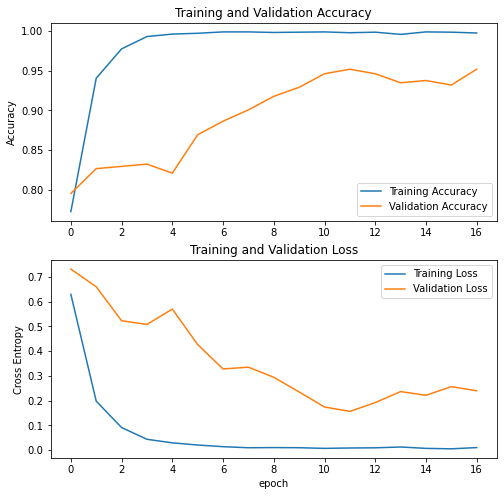

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test Model


In [26]:
test_acc = model.evaluate(test, verbose=1)[1]
print('test acc:', str(round(test_acc*100, 3))+"%")

367/367 [==============================] - 4s 9ms/step - loss: 0.2381 - accuracy: 0.9510
test acc: 95.095%


## Save model

In [4]:
SAVE_DIR = './MODELS/'
TFLITE_DIR = './MODELS/TFLITE/'

In [28]:
def save_model(model,filename):
    print('model saving to ', filename, '... ')
    model.save_weights('weights.h5')
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)

    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('weights.h5')
    loaded_model.save(filename)

In [29]:
save_model(model,SAVE_DIR+"MOBILENET_FLOWERS.h5")

model saving to  ./MODELS/MOBILENET_FLOWERS.h5 ... 


In [57]:
model.save(SAVE_DIR+"MOBILENET_FLOWERS_NOCUSTOM.h5", include_optimizer=False)

# Convert Keras model to TF-Lite model

## TF-Lite Model



In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


FILE = TFLITE_DIR+'MOBILENETV2_FLOWERS.tflite'
with open(FILE, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmpwkn9s4nt\assets


INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmpwkn9s4nt\assets


## FP16


In [31]:
converter_FP16 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_FP16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_FP16.target_spec.supported_types = [tf.float16]
tflite_FP16_model = converter_FP16.convert()

FILE_FP16 = TFLITE_DIR+'MOBILENETV2_FLOWERS_FP16_QUANT.tflite'
with open(FILE_FP16, "wb") as f:
    f.write(tflite_FP16_model)

INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmpkho_ogdu\assets


INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmpkho_ogdu\assets


**REPRESENTATIVE DATASET**

In [33]:
def representative_dataset():
    for batch in test.take(255):
        yield [batch[0]]

## INT WITH FLOAT FALLBACK

In [34]:
converter_INT_FLOATF = tf.lite.TFLiteConverter.from_keras_model(model)
converter_INT_FLOATF.optimizations = [tf.lite.Optimize.DEFAULT]
converter_INT_FLOATF.representative_dataset = representative_dataset
tflite_INT_FLOATF_model = converter_INT_FLOATF.convert()

FILE_INT_FLOATF = TFLITE_DIR+'MOBILENETV2_FLOWERS_INTwFLOAT_FALLBACK_QUANT.tflite'
with open(FILE_INT_FLOATF, "wb") as f:
    f.write(tflite_INT_FLOATF_model)

INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmpbzjv3jju\assets


INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmpbzjv3jju\assets
C:\Users\nikita\AppData\Roaming\Python\Python39\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


## INT ONLY

In [35]:
converter_INT_ONLY = tf.lite.TFLiteConverter.from_keras_model(model)
converter_INT_ONLY.optimizations = [tf.lite.Optimize.DEFAULT]
converter_INT_ONLY.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_INT_ONLY.inference_input_type = tf.uint8
converter_INT_ONLY.inference_output_type = tf.uint8
converter_INT_ONLY.representative_dataset = representative_dataset
tflite_INT_ONLY_model = converter_INT_ONLY.convert()


FILE_INT_ONLY = TFLITE_DIR+'MOBILENETV2_FLOWERS_INT_ONLY_QUANT.tflite'
with open(FILE_INT_ONLY, "wb") as f:
    f.write(tflite_INT_ONLY_model)

INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmpe2p499fa\assets


INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmpe2p499fa\assets
C:\Users\nikita\AppData\Roaming\Python\Python39\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


## INT8 WEIGHTS, INT16 ACTIVATIONS

In [36]:
converter_INT8_INT16 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_INT8_INT16.representative_dataset = representative_dataset
converter_INT8_INT16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_INT8_INT16.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
tflite_INT8_INT16_model = converter_INT8_INT16.convert()

FILE_INT8_INT16_ONLY = TFLITE_DIR+'MOBILENETV2_FLOWERS_INT8weights_INT16activations_QUANT.tflite'
with open(FILE_INT8_INT16_ONLY, "wb") as f:
    f.write(tflite_INT8_INT16_model)

INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmpwr7qvwcf\assets


INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmpwr7qvwcf\assets


## EVALUATE GENERAL MODEL

In [38]:
import datetime
import time

total_seen = 0
num_correct = 0
inference_time = []

for batch in tqdm(test.take(int(num_test))):
    image = batch[0].numpy()

    start_ms = time.time()

    predictions = model.predict(image)

    elapsed_ms = time.time() - start_ms
    inference_time.append(elapsed_ms * 1000.0)

    if batch[1].numpy() == predictions.argmax():
        num_correct += 1
    total_seen += 1

    if total_seen % 50 == 0:
        print("Accuracy after %i images: %f" %
          (total_seen, float(num_correct) / float(total_seen)))
        
print('Num images: {0:}, Accuracy: {1:.4f}, Latency: {2:.2f} ms'.format(num_test,
                                                                        float(num_correct / total_seen),
                                                                        np.array(inference_time).mean()))

 14%|███████████▋                                                                     | 53/367 [00:03<00:17, 17.84it/s]

Accuracy after 50 images: 0.920000


 28%|██████████████████████▍                                                         | 103/367 [00:06<00:14, 17.73it/s]

Accuracy after 100 images: 0.950000


 42%|█████████████████████████████████▎                                              | 153/367 [00:09<00:12, 17.78it/s]

Accuracy after 150 images: 0.946667


 55%|████████████████████████████████████████████▎                                   | 203/367 [00:12<00:09, 17.82it/s]

Accuracy after 200 images: 0.950000


 69%|███████████████████████████████████████████████████████▏                        | 253/367 [00:14<00:06, 17.66it/s]

Accuracy after 250 images: 0.952000


 82%|█████████████████████████████████████████████████████████████████▌              | 301/367 [00:17<00:04, 14.38it/s]

Accuracy after 300 images: 0.953333


 96%|████████████████████████████████████████████████████████████████████████████▋   | 352/367 [00:19<00:00, 25.81it/s]

Accuracy after 350 images: 0.951429


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [00:20<00:00, 18.11it/s]

Num images: 367, Accuracy: 0.9510, Latency: 54.29 ms


## TF-Lite Model


In [86]:
y_test = list(map(lambda x: np.asarray(x[1])[0], test))
y_test

[2,
 3,
 3,
 4,
 3,
 0,
 0,
 0,
 0,
 1,
 3,
 2,
 4,
 1,
 2,
 1,
 2,
 4,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 3,
 0,
 1,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 1,
 0,
 3,
 0,
 4,
 4,
 3,
 0,
 4,
 3,
 3,
 2,
 4,
 0,
 1,
 2,
 1,
 3,
 0,
 1,
 4,
 1,
 0,
 2,
 3,
 0,
 0,
 4,
 0,
 1,
 1,
 0,
 1,
 2,
 4,
 3,
 3,
 0,
 3,
 2,
 2,
 1,
 0,
 3,
 2,
 0,
 0,
 4,
 3,
 0,
 3,
 3,
 2,
 0,
 2,
 1,
 4,
 0,
 3,
 3,
 3,
 1,
 4,
 0,
 4,
 4,
 4,
 4,
 0,
 4,
 2,
 3,
 4,
 0,
 0,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 3,
 3,
 0,
 3,
 2,
 0,
 1,
 2,
 1,
 4,
 3,
 0,
 2,
 0,
 2,
 2,
 4,
 0,
 3,
 0,
 0,
 1,
 2,
 0,
 1,
 2,
 3,
 1,
 2,
 2,
 0,
 3,
 3,
 4,
 0,
 4,
 0,
 4,
 0,
 2,
 2,
 1,
 0,
 2,
 4,
 0,
 0,
 0,
 1,
 1,
 0,
 4,
 1,
 4,
 4,
 3,
 1,
 0,
 1,
 2,
 3,
 4,
 0,
 0,
 3,
 2,
 4,
 1,
 0,
 0,
 4,
 4,
 2,
 0,
 3,
 4,
 0,
 0,
 1,
 3,
 2,
 0,
 2,
 2,
 3,
 4,
 0,
 1,
 4,
 1,
 0,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 0,
 4,
 2,
 4,
 1,
 0,
 0,
 4,
 2,
 1,
 0,
 3,
 2,
 1,
 4,
 3,
 1,
 3,
 0,
 0,
 2,
 3,
 4,
 0,
 1,
 2,
 4,
 0,
 3,
 1,
 0,
 1,
 2,
 4,
 0,


In [96]:
def evaluate_tflite(mode_path, num_test):
    interpreter = tf.lite.Interpreter(model_path=mode_path)

    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    print('input_details:  ', input_details)
    print('output_details: ', output_details)
    top_indices_tflite = []
    total_seen = 0
    num_correct = 0
    inference_time = []

    for batch in tqdm(test.take(int(num_test))):
        image = batch[0].numpy()
        start_ms = time.time()
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            image = image / input_scale + input_zero_point
        
        image = image.astype(input_details["dtype"])
        interpreter.set_tensor(interpreter.get_input_details()[0]["index"], image)
        interpreter.invoke()
        preds = interpreter.get_tensor(output_details["index"])
        top_inds = preds.argsort()[:,-5:][:,::-1]
        top_indices_tflite.append(top_inds[0])
        elapsed_ms = time.time() - start_ms
        inference_time.append(elapsed_ms * 1000.0)
        
        total_seen += 1

        if total_seen % 500 == 0:
            print("Accuracy after %i images: %f" %
              (total_seen, float(num_correct) / float(total_seen)))
    
    top_indices_tflite = np.array(top_indices_tflite)
    print('top-1 tflite accuracy:',np.mean(top_indices_tflite[:,0]==y_test[:len(top_indices_tflite)]))
    arr_of_k=[2,3,4,5]
    for k in arr_of_k:
        print('top-{} accuracy:'.format(k),
              np.mean(np.sum(top_indices_tflite[:,:k]==np.repeat(np.reshape(y_test,(-1,1)),k,axis=1),axis=1)))
# #     return np.array(top_indices_tflit

#     print('Num images: {0:}, Accuracy: {1:.4f}, Latency: {2:.2f} ms'.format(num_test,
#                                                                          float(num_correct / total_seen),
#                                                                          np.array(inference_time).mean()))

### GENERAL TFLITE

In [88]:
model_path_no_quant = TFLITE_DIR+'MOBILENETV2_FLOWERS.tflite'
evaluate_tflite(model_path1, int(num_test))

input_details:   {'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output_details:  {'name': 'StatefulPartitionedCall:0', 'index': 177, 'shape': array([1, 5]), 'shape_signature': array([-1,  5]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [00:04<00:00, 78.36it/s]

top-1 tflite accuracy: 0.9509536784741145
top-2 accuracy: 0.989100817438692
top-3 accuracy: 0.9918256130790191
top-4 accuracy: 1.0
top-5 accuracy: 1.0


### FP16

In [98]:
model_path_FP16 = TFLITE_DIR+'MOBILENETV2_FLOWERS_FP16_QUANT.tflite'
evaluate_tflite(model_path_FP16, int(num_test))

input_details:   {'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output_details:  {'name': 'StatefulPartitionedCall:0', 'index': 177, 'shape': array([1, 5]), 'shape_signature': array([-1,  5]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [00:04<00:00, 78.93it/s]

top-1 tflite accuracy: 0.9509536784741145
top-2 accuracy: 0.989100817438692
top-3 accuracy: 0.9945504087193461
top-4 accuracy: 1.0
top-5 accuracy: 1.0


### INT ONLY

In [97]:
model_path_INT_ONLY = TFLITE_DIR+'MOBILENETV2_FLOWERS_INT_ONLY_QUANT.tflite'
evaluate_tflite(model_path_INT_ONLY, int(num_test))

input_details:   {'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([0]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output_details:  {'name': 'StatefulPartitionedCall:0', 'index': 179, 'shape': array([1, 5]), 'shape_signature': array([-1,  5]), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([0]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [10:55<00:00,  1.79s/it]

top-1 tflite accuracy: 0.9455040871934605
top-2 accuracy: 0.989100817438692
top-3 accuracy: 0.997275204359673
top-4 accuracy: 1.0
top-5 accuracy: 1.0


### INT8 WEIGHTS AND INT16 ACTIVATIONS

In [99]:
model_path_INT8_INT16 = TFLITE_DIR+'MOBILENETV2_FLOWERS_INT8weights_INT16activations_QUANT.tflite'
evaluate_tflite(model_path_INT8_INT16, int(num_test))

input_details:   {'name': 'serving_default_input_3:0', 'index': 178, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output_details:  {'name': 'StatefulPartitionedCall:0', 'index': 179, 'shape': array([1, 5]), 'shape_signature': array([-1,  5]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [01:43<00:00,  3.55it/s]

top-1 tflite accuracy: 0.9455040871934605
top-2 accuracy: 0.9863760217983651
top-3 accuracy: 0.997275204359673
top-4 accuracy: 1.0
top-5 accuracy: 1.0


### INT WITH FLOAT FALLBCAK

In [100]:
model_path_INTWFLOAT = TFLITE_DIR+'MOBILENETV2_FLOWERS_INTwFLOAT_FALLBACK_QUANT.tflite'
evaluate_tflite(model_path_INTWFLOAT, int(num_test))

input_details:   {'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output_details:  {'name': 'StatefulPartitionedCall:0', 'index': 179, 'shape': array([1, 5]), 'shape_signature': array([-1,  5]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [10:59<00:00,  1.80s/it]

top-1 tflite accuracy: 0.9455040871934605
top-2 accuracy: 0.989100817438692
top-3 accuracy: 0.997275204359673
top-4 accuracy: 1.0
top-5 accuracy: 1.0


# MODEL SIZES EVALUATIONS


In [5]:
# DICT OF SIZES INIT
DICT_OF_SIZES = dict()
for MODEL in os.listdir(TFLITE_DIR):
    DICT_OF_SIZES[MODEL] = os.stat(TFLITE_DIR + MODEL).st_size
    
# DATAFRAME OF SIZES INIT
DATA_OF_SIZES = pd.DataFrame.from_dict(DICT_OF_SIZES,orient='index', columns=['SIZE (BYTES)'])

# SIZES OF GENERAL MOBILENET AND TFLITE MOBILENET (NO QUANT)
SIZE_OF_GENERAL_MOBILENET_MODEL = os.stat(SAVE_DIR + 'MOBILENET_FLOWERS.h5').st_size
SIZE_OF_TFLITE_MOBILENET_MODEL = os.stat(TFLITE_DIR + 'MOBILENETV2_FLOWERS.tflite').st_size

# INIT SIZE REDUCEMENT ARRAY
SIZE_REDUCEMENT_MOBILENET = np.array(round(SIZE_OF_GENERAL_MOBILENET_MODEL / DATA_OF_SIZES.iloc[:,0:], 3))
SIZE_REDUCEMENT_MOBILENET_TFLITE = np.array(round(SIZE_OF_TFLITE_MOBILENET_MODEL / DATA_OF_SIZES.iloc[:,0:], 3))

# NEW ROWS
DATA_OF_SIZES['SIZE REDUCEMENT TO .h5 CHECKPOINT'] = [str(size[0]) + 'x size reducement' for size in SIZE_REDUCEMENT_MOBILENET]
DATA_OF_SIZES['SIZE REDUCEMENT TO NO QUANT'] = [str(size[0]) + 'x size reducement' for size in SIZE_REDUCEMENT_MOBILENET_TFLITE]

# GENERAL MODEL
GENERAL_MODEL = pd.DataFrame([[SIZE_OF_GENERAL_MOBILENET_MODEL, "general model", "general model"]], 
                             columns=DATA_OF_SIZES.columns, index=['MOBILENET_FLOWERS.h5'])
DATA_OF_SIZES = DATA_OF_SIZES.append(GENERAL_MODEL)
DATA_OF_SIZES

SIZE (BYTES)  \
MOBILENETV2_FLOWERS.tflite                               8884484   
MOBILENETV2_FLOWERS_FP16_QUANT.tflite                    4473072   
MOBILENETV2_FLOWERS_INT8weights_INT16activation...       2917824   
MOBILENETV2_FLOWERS_INTwFLOAT_FALLBACK_QUANT.tf...       2710704   
MOBILENETV2_FLOWERS_INT_ONLY_QUANT.tflite                2710720   
MOBILENETV2_FLOWERS_PRUNED+QUANTIZED.tflite              2643208   
MOBILENETV2_FLOWERS_PRUNED.tflite                        8884484   
MOBILENETV2_FLOWERS_QAT.tflite                           2713488   
MOBILENET_FLOWERS.h5                                     9536184   

                                                   SIZE REDUCEMENT TO .h5 CHECKPOINT  \
MOBILENETV2_FLOWERS.tflite                                    1.073x size reducement   
MOBILENETV2_FLOWERS_FP16_QUANT.tflite                         2.132x size reducement   
MOBILENETV2_FLOWERS_INT8weights_INT16activation...            3.268x size reducement   
MOBILENETV2_FLOWERS_INTwFLOAT_FALLBACK_QUANT.tf...            3.518x size reducement   
MOBILENETV2_FLOWERS_INT_ONLY_QUANT.tflite                     3.518x size reducement   
MOBILENETV2_FLOWERS_PRUNED+QUANTIZED.tflite                   3.608x size reducement   
MOBILENETV2_FLOWERS_PRUNED.tflite                             1.073x size reducement   
MOBILENETV2_FLOWERS_QAT.tflite                                3.514x size reducement   
MOBILENET_FLOWERS.h5                                                   general model   

                                                   SIZE REDUCEMENT TO NO QUANT  
MOBILENETV2_FLOWERS.tflite                                1.0x size reducement  
MOBILENETV2_FLOWERS_FP16_QUANT.tflite                   1.986x size reducement  
MOBILENETV2_FLOWERS_INT8weights_INT16activation...      3.045x size reducement  
MOBILENETV2_FLOWERS_INTwFLOAT_FALLBACK_QUANT.tf...      3.278x size reducement  
MOBILENETV2_FLOWERS_INT_ONLY_QUANT.tflite               3.278x size reducement  
MOBILENETV2_FLOWERS_PRUNED+QUANTIZED.tflite             3.361x size reducement  
MOBILENETV2_FLOWERS_PRUNED.tflite                         1.0x size reducement  
MOBILENETV2_FLOWERS_QAT.tflite                          3.274x size reducement  
MOBILENET_FLOWERS.h5                                             general model

In [6]:
# COMPARE TO GENERAL MODEL
DATA_OF_SIZES.iloc[:,0:1].plot.barh()

In [9]:
# COMPARE TO TFLITE MODEL (NO QUANT)
DATA_OF_SIZES.iloc[:8,0:1].plot.barh()